<a href="https://colab.research.google.com/github/clachevv/neuro-match-project/blob/main/notebooks/380_pca_loaded_from_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive') # /content/drive/MyDrive/neuromatch

Mounted at /content/drive


In [3]:
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr

In [4]:
train, test = {},{}
for i in range(8):
    train[f'layer_{i+1}'] = np.load(f"/content/drive/MyDrive/neuromatch/pca_100_380videos/train_layer_{i+1}.npy")
    test[f'layer_{i+1}'] = np.load(f"/content/drive/MyDrive/neuromatch/pca_100_380videos/test_layer_{i+1}.npy")

In [5]:
# this loads result from AlexNet Classification (with LLM reduction)
classes = pd.read_csv('/content/drive/MyDrive/neuromatch/NEW 380 video cats.csv', header=0)
classes['video_path'] = classes['video_id']
classes['video_id'] = classes['video_id'].str.split("/").str.get(3)
classes = classes[classes['index'] <= 1000]
classes['feat_index'] = classes['index'] + 1
dicty = classes[['feat_index','llm_classes']]

In [6]:
filtered_train = {}
for layer, activation_weights in train.items():
    each_layer_df = pd.DataFrame(activation_weights).reset_index()
    each_layer_df['index'] = each_layer_df['index']+1
    each_layer_df.columns = ['feat_' + str(item) for item in each_layer_df.columns]
    filtered_layer = each_layer_df.merge(dicty, on = 'feat_index', how='right')
    filtered_train[layer] = filtered_layer

In [7]:
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append(f"layer_{i + 1}")

filtered_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  maping_video_classes = dict(zip(filtered_train[layer].index, filtered_train[layer]['llm_classes']))
  activation_array = filtered_train[layer].drop(columns=['feat_index','llm_classes']).to_numpy()
  filtered_RDMs[layer] = 1- np.corrcoef(activation_array)

In [8]:
final_df = pd.DataFrame()
for sub_ROI, weights in filtered_RDMs.items():
    df = pd.DataFrame(weights)
    df.columns = ["video_"+str(col) for col in df.columns]
    df['sub_ROI'] = sub_ROI
    df = df.reset_index()
    df['index'] =  "video_" + df['index'].astype(str)
    final_df = pd.concat([final_df,df])

final_df.to_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_alexnet380.csv",index=False)

In [9]:
replacements = {
    'Natural Phenomena and Places':'Natural\nPhenomena\nand Places',
    'Objects and Tools':'Objects\nand\nTools',
    'Sports and Recreation':'Sports\nand\nRecreation'
}

for key, value in maping_video_classes.items():
    if value in replacements:
        maping_video_classes[key] = replacements[value]

In [10]:
stimuli_classes = list(maping_video_classes.values())
unique_classes = set(stimuli_classes)
class_indices = {cls: [] for cls in unique_classes}
for idx, cls in enumerate(stimuli_classes):
    class_indices[cls].append(idx)

end_indices = [indices[-1] + 0.5 for indices in class_indices.values()]
end_indices.sort()

Text(0.5, 1.0, 'AlexNet Stimuli RDM')

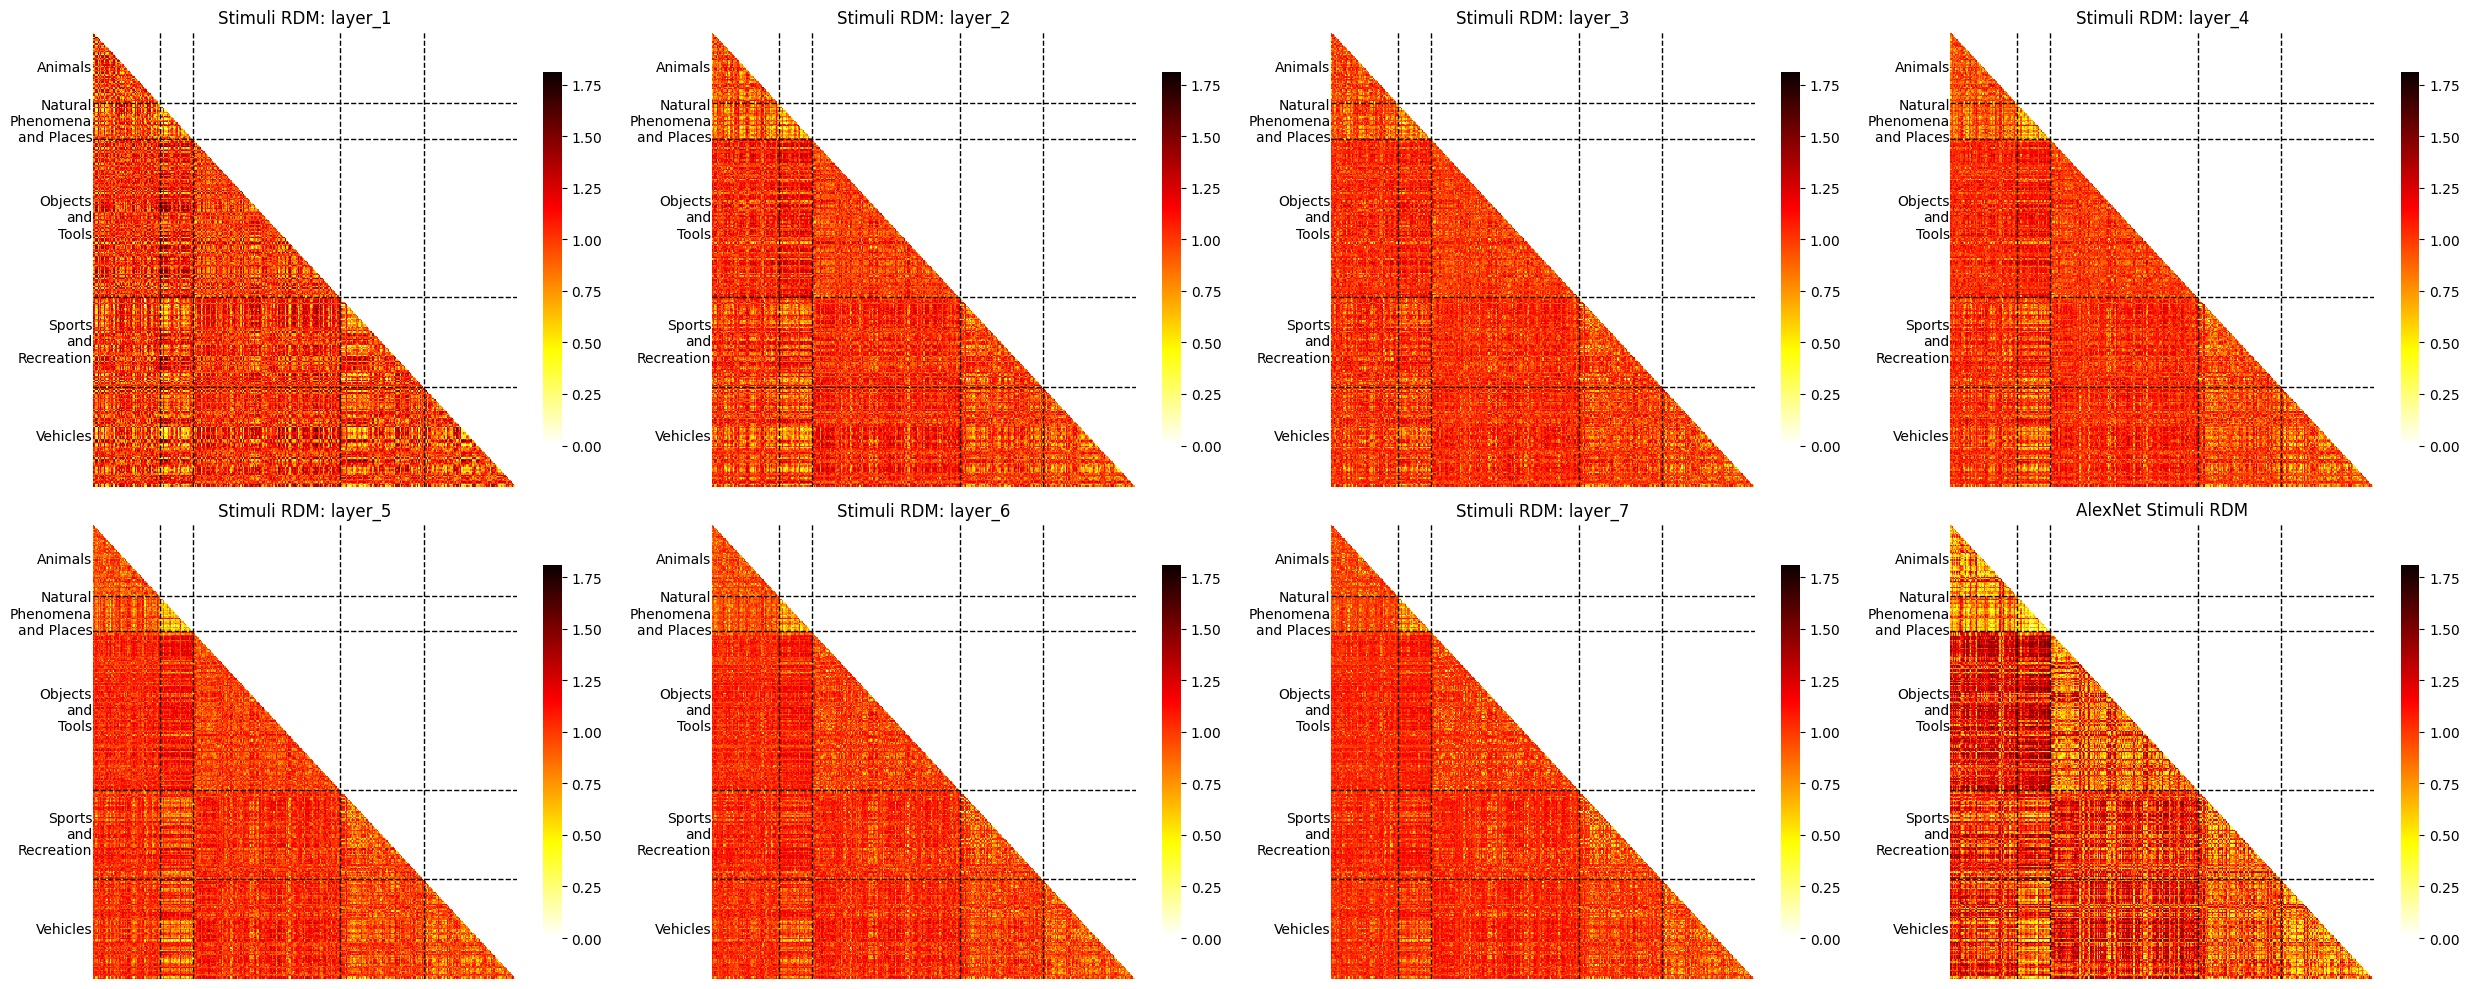

In [11]:
def create_rdm_plot(layer,ax):
    stimuli_classes = list(maping_video_classes.values())
    rdm = filtered_RDMs[layer]
    mask = np.triu(np.ones_like(rdm, dtype=bool))
    # RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

    # Create the heatmap
    vmin=0 ;vmax=1.81
    sns.heatmap(rdm, mask=mask, cmap='hot_r',vmin=vmin, vmax=vmax, square=False, cbar_kws={"shrink": .82}, ax=ax)

    # Calculate class boundaries for annotation
    for end in end_indices[:-1]:  # Exclude the last boundary to avoid drawing a line after the last class
        ax.axvline(x=end, color='black', linestyle='--', linewidth=1)
        ax.axhline(y=end, color='black', linestyle='--', linewidth=1)

    # Annotate the x-axis with a single label at the center of each class
    for cls, indices in class_indices.items():
        middle = int(np.mean(indices))
        ax.text(-0.5, middle, cls, ha='right', va='center', fontsize=10, color='black', rotation=0, transform=ax.transData)

    ax.set_title(f"Stimuli RDM: {layer}")
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.show()

fig, axes = plt.subplots(2,4, figsize=(25,10))
axes = axes.flatten()
layers = [f'layer_{i}' for i in range(1,9)]
for ax,layer in zip(axes,layers):
    create_rdm_plot(layer,ax)

plt.tight_layout()
plt.title("AlexNet Stimuli RDM")

In [ ]:
# general correlation

In [12]:
alex = pd.read_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_alexnet380.csv")
fmri = pd.read_csv("/content/drive/MyDrive/neuromatch/results/rdm_values_fmri380.csv")

In [71]:
fmri['classes_val']=fmri['index'].str.split("_").str.get(1).astype(int)
fmri['classes']=np.where(fmri.classes_val <= 54, 'Animals',
np.where(fmri.classes_val <= 81, 'Natural Phenomena and Places',
np.where(fmri.classes_val <= 201, 'Objects and Tools',
np.where(fmri.classes_val <= 269, 'Sports and Recreation',
np.where(fmri.classes_val <= 344, 'Vehicles', fmri.classes_val
)))))

alex['classes_val']=alex['index'].str.split("_").str.get(1).astype(int)
alex['classes']=np.where(alex.classes_val <= 54, 'Animals',
np.where(alex.classes_val <= 81, 'Natural Phenomena and Places',
np.where(alex.classes_val <= 201, 'Objects and Tools',
np.where(alex.classes_val <= 269, 'Sports and Recreation',
np.where(alex.classes_val <= 344, 'Vehicles', alex.classes_val
)))))

In [13]:
array1= alex.sub_ROI.unique()
array2= fmri.sub_ROI.unique()
pairs = np.array(np.meshgrid(array1, array2)).T.reshape(-1, 2)
pairs

output = pd.DataFrame()
counter = 0
for pair in pairs:
    # print(pair)
    alex_ind = alex[alex.sub_ROI == pair[0]].drop(columns=['index','sub_ROI']).to_numpy()
    fmri_ind = fmri[fmri.sub_ROI == pair[1]].drop(columns=['index','sub_ROI']).to_numpy()

    fmri_ind = fmri_ind[np.triu_indices_from(fmri_ind, k=1)]
    alex_ind = alex_ind[np.triu_indices_from(alex_ind, k=1)]

    pearson_corr, p_value_pearson = pearsonr(fmri_ind, alex_ind)
    spearman_corr, p_value_spearman = spearmanr(fmri_ind, alex_ind)

    data = {
            "alexnet_layer" : pair[0],
            "fmri_roi" : pair[1],
            "pearson_corr" : pearson_corr,
            "p_value_pearson" : p_value_pearson,
            # "spearman_corr" = spearman_corr,
            # "p_value_spearman" = p_value_spearman,
    }
    df = pd.DataFrame(data, index=[counter])
    counter +=1
    output = pd.concat([output, df])

output['roi'] = output.fmri_roi.str.split("_").str.get(1)
output[output.p_value_pearson < .05].sort_values(by='pearson_corr',ascending=False).to_csv("/content/drive/MyDrive/neuromatch/results/corr_results_values.csv",index=False)

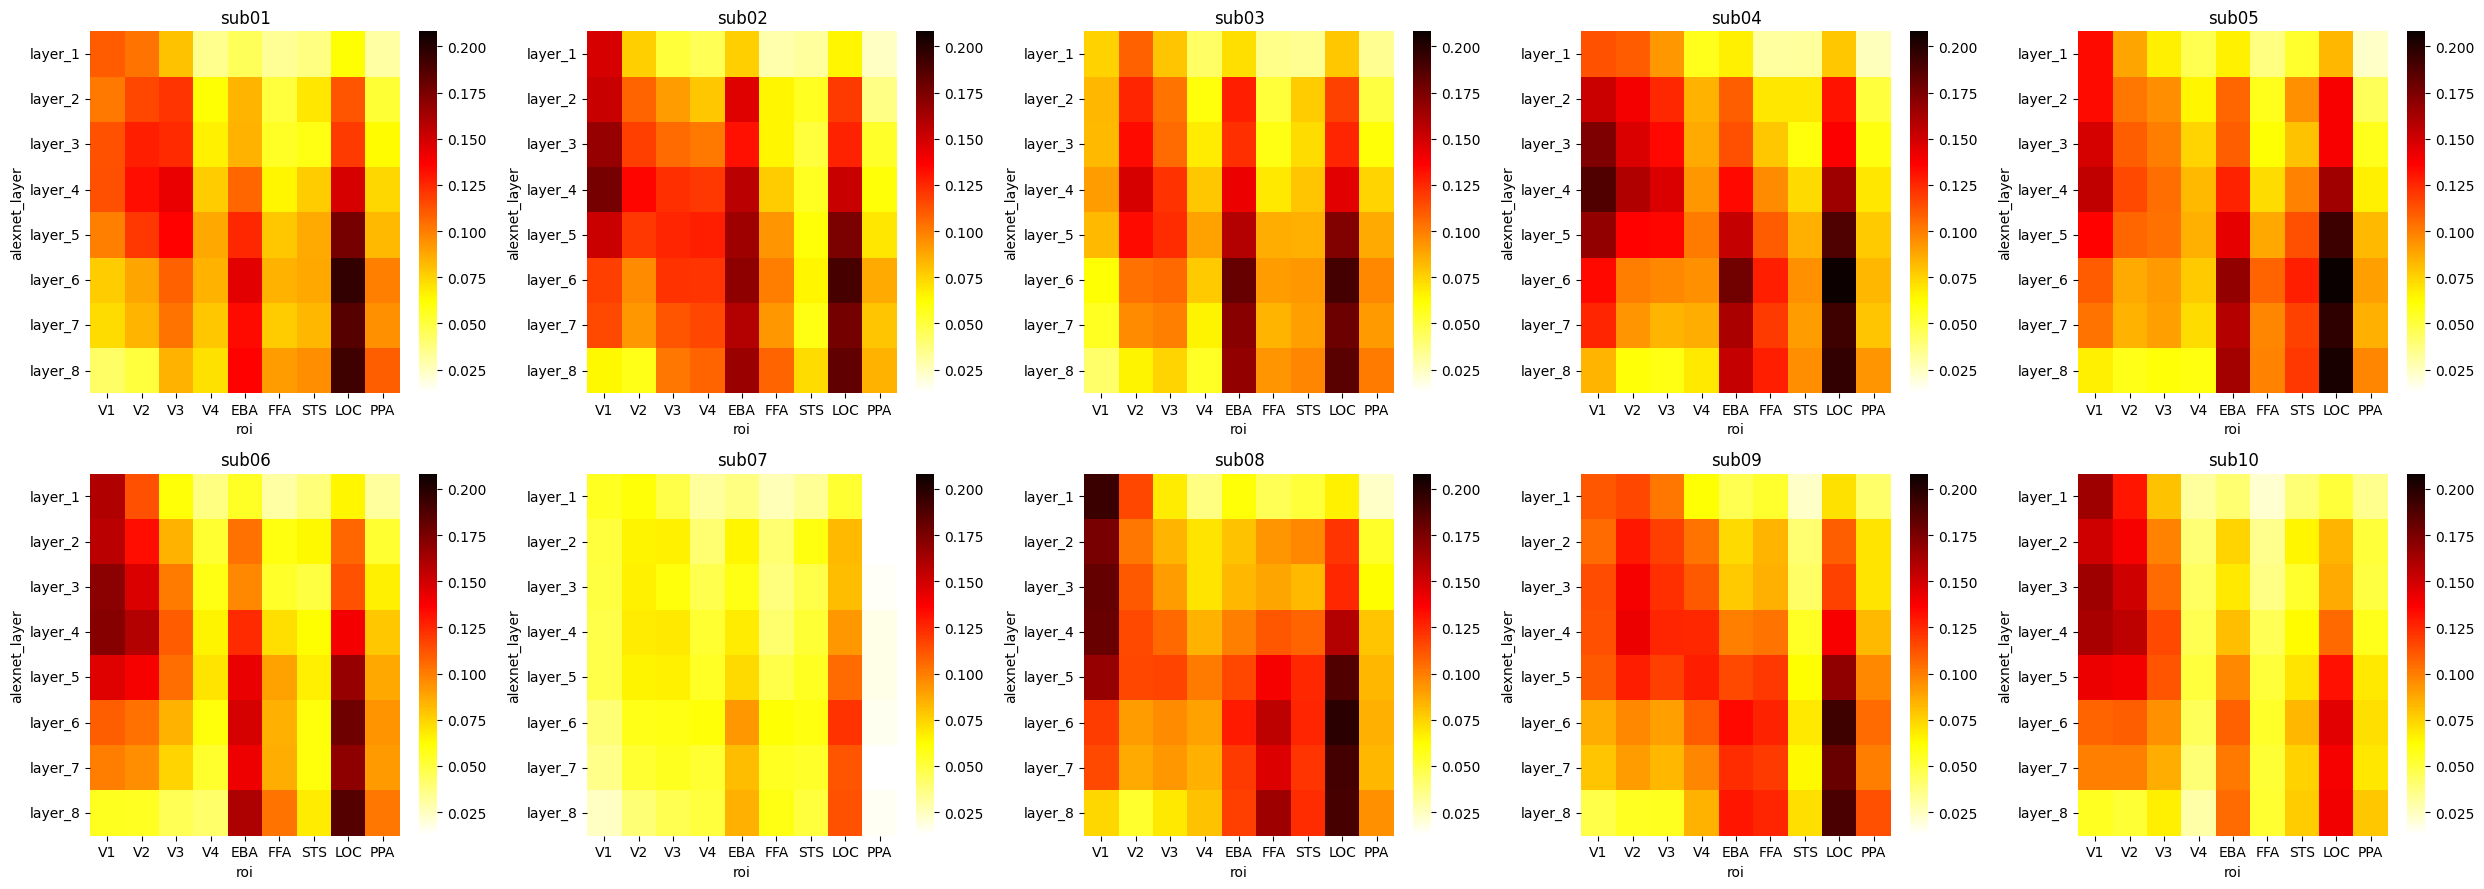

In [15]:
output = pd.read_csv("/content/drive/MyDrive/neuromatch/results/corr_results_values.csv")
output['subject'] = output.fmri_roi.str.split("_").str.get(0)

fig, axes = plt.subplots(2,5,figsize=(25,9))
axes = axes.flatten()

roi_order = ['V1', 'V2', 'V3','V4','EBA','FFA', 'STS', 'LOC', 'PPA']
subjects_order = output.subject.sort_values().unique()
average_data = {}
for ax, sub in zip(axes, subjects_order):
    sub_data = output[output.subject == sub].drop(columns=['fmri_roi'])
    heatmap_df = sub_data.groupby(['alexnet_layer','roi']).pearson_corr.sum().unstack()#.reset_index()
    vmin,vmax=output.pearson_corr.min(), output.pearson_corr.max()
    try:
        reordered_data = heatmap_df[roi_order]
    except:
        reordered_data = heatmap_df[['V1', 'V2', 'V3','V4','EBA','FFA', 'STS', 'LOC']]

    sns.heatmap(reordered_data, vmin=vmin, vmax=vmax, cmap='hot_r',ax=ax)
    ax.set_title(sub)
    average_data[sub]=reordered_data.to_numpy()

plt.tight_layout()

Text(0.5, 1.0, 'Average between subjects')

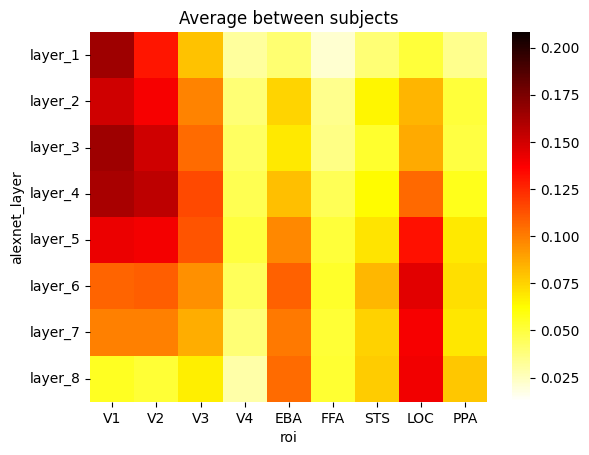

In [16]:
# Get the size of the matrices
matrix_size = average_data['sub10'].shape

# Initialize an accumulator matrix
accumulator = np.zeros(matrix_size)

# Sum all matrices
for matrix in average_data.values():
    matrix = np.nan_to_num(matrix, nan=0)
    try:
        accumulator += matrix
    except:
        zero_array = np.zeros((8, 1))
        matrix = np.hstack((matrix, zero_array))
        accumulator += matrix

    # print(accumulator)
    # print("######################")

# Calculate the average matrix
average_matrix = accumulator / len(average_data)
heat_map = pd.DataFrame(columns =heatmap_df.columns, data = average_matrix, index=heatmap_df.index)
sns.heatmap(reordered_data, vmin=vmin, vmax=vmax, cmap='hot_r')
plt.title("Average between subjects")

In [ ]:
# classes correlations

In [111]:
array1= alex.sub_ROI.unique()
array2= fmri.sub_ROI.unique()
array3= fmri.classes.unique()
grid = np.meshgrid(array1, array2, array3, indexing='ij')
combinations = np.stack(grid, axis=-1).reshape(-1, 3)

output = pd.DataFrame()
counter = 0
for trio in combinations:
    alex_ind = alex[(alex.sub_ROI == trio[0])&(alex.classes == trio[2])].drop(columns=['index','sub_ROI','classes_val','classes']).to_numpy()
    fmri_ind = fmri[(fmri.sub_ROI == trio[1])&(fmri.classes == trio[2])].drop(columns=['index','sub_ROI','classes_val','classes']).to_numpy()

    fmri_ind = fmri_ind[np.triu_indices_from(fmri_ind, k=1)]
    alex_ind = alex_ind[np.triu_indices_from(alex_ind, k=1)]

    pearson_corr, p_value_pearson = pearsonr(fmri_ind, alex_ind)
    spearman_corr, p_value_spearman = spearmanr(fmri_ind, alex_ind)

    data = {
            "alexnet_layer" : trio[0],
            "fmri_roi" : trio[1],
            "class" : trio[2],
            "pearson_corr" : pearson_corr,
            "p_value_pearson" : p_value_pearson,
            # "spearman_corr" = spearman_corr,
            # "p_value_spearman" = p_value_spearman,
    }
    df = pd.DataFrame(data, index=[counter])
    counter +=1
    output = pd.concat([output, df])

output['roi'] = output.fmri_roi.str.split("_").str.get(1)
output = output[output.p_value_pearson < .05].sort_values(by='pearson_corr',ascending=False)#.to_csv("/content/drive/MyDrive/neuromatch/results/corr_results_values.csv",index=False)

In [120]:
output['subject'] = output.fmri_roi.str.split("_").str.get(0)
roi_order = ['V1', 'V2', 'V3','V4','EBA','FFA', 'STS', 'LOC', 'PPA']
classes = ['Animals', 'Natural Phenomena and Places', 'Objects and Tools','Sports and Recreation', 'Vehicles']
subjects_order = output.subject.sort_values().unique()

classes_data = {}
for cla in classes:
    average_data = {}
    for sub in subjects_order:
        sub_data = output[(output.subject == sub)&(output['class']==cla)].drop(columns=['fmri_roi','class'])
        heatmap_df = sub_data.groupby(['alexnet_layer','roi']).pearson_corr.sum().unstack()
        try:
            reordered_data = heatmap_df[roi_order]
        except:
            reordered_data = heatmap_df[['V1', 'V2', 'V3','V4','EBA','FFA', 'STS', 'LOC']]

        average_data[sub]=reordered_data.to_numpy()
    classes_data[cla] = average_data

In [122]:
# Get the size of the matrices
matrix_size = classes_data['Animals']['sub01'].shape

# Initialize an accumulator matrix
# accumulator = np.zeros(matrix_size)


# Sum all matrices
average_matrix = {}
for cla,subjects in classes_data.items():
    accumulator = np.zeros(matrix_size)
    for matrix in subjects.values():
        matrix = np.nan_to_num(matrix, nan=0)
        try:
            accumulator += matrix
        except:
            zero_array = np.zeros((8, 1))
            matrix = np.hstack((matrix, zero_array))
            accumulator += matrix
    average_matrix[cla] = accumulator / len(average_data)
    # print(accumulator)
    # print("######################")

Text(0.5, 1.05, 'Average between Subjects')

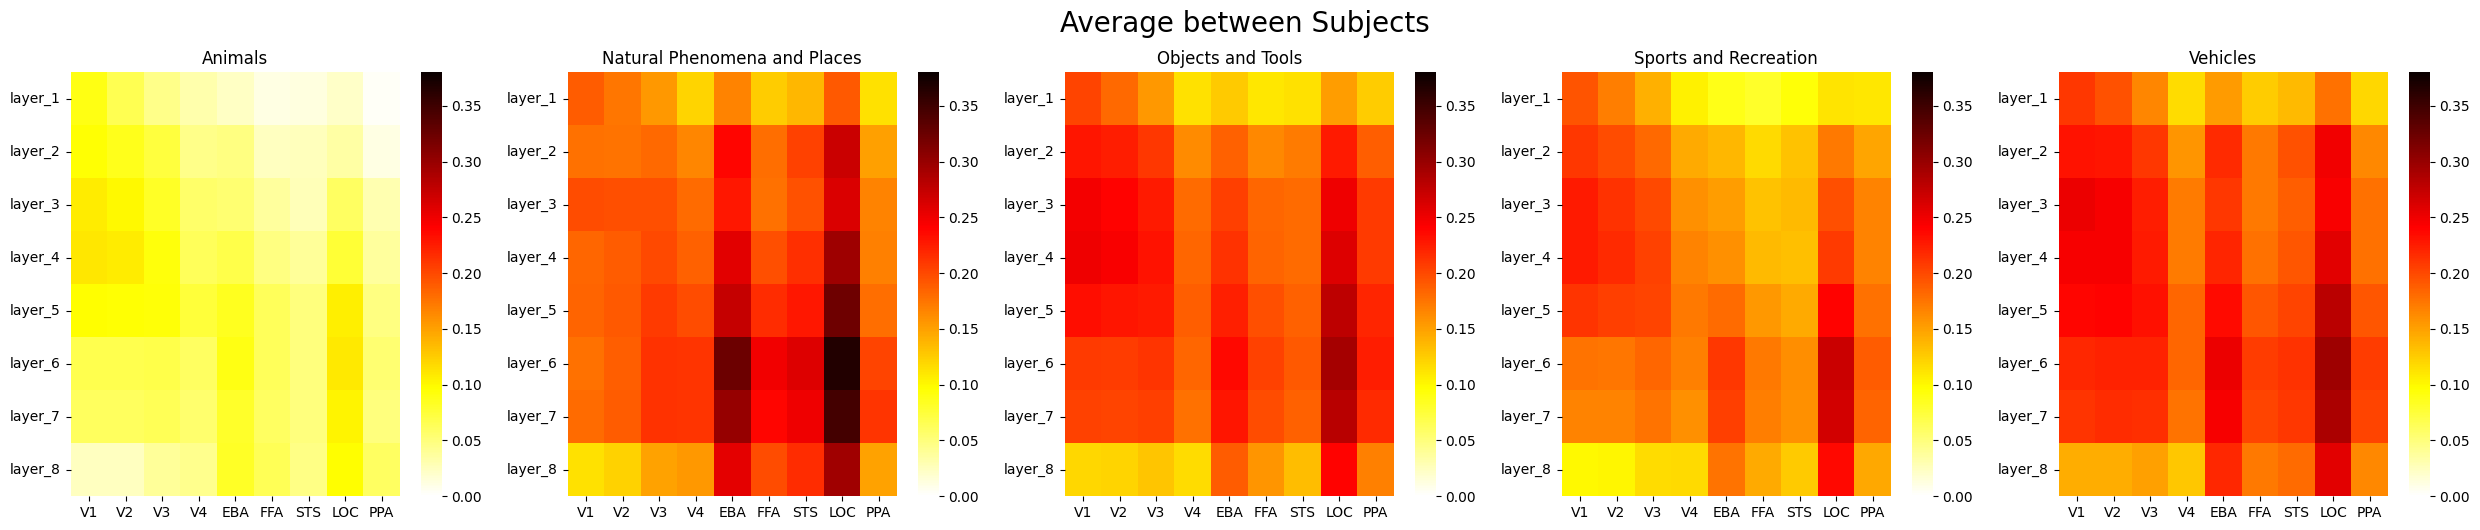

In [132]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
axes = axes.flatten()

for i, (key, matrix) in enumerate(average_matrix.items()):

    heat_map = pd.DataFrame(columns =reordered_data.columns, data = matrix, index=reordered_data.index)
    vmin=0;vmax=0.38
    sns.heatmap(heat_map,vmin=0,vmax=vmax, cmap='hot_r', ax=axes[i])
    axes[i].set_title(f"{key}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()

fig.suptitle('Average between Subjects', fontsize=20, y=1.05)